In [1]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import glob
from tqdm import tqdm
from sklearn.utils import shuffle
from scipy.optimize import minimize
from scipy.stats import poisson
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer


def get_N_matrix(topic, verbose=True, drop_subsumed=True, drop_medium_specific=True):
    verboseprint = print
    MEDIA = ['NachDenkSeiten', 'DER SPIEGEL', 'ZDFheute Nachrichten', 'BILD', 'Junge Freiheit']
    cv = CountVectorizer(max_df=0.9, min_df=10, max_features=10000, ngram_range=(1,3))

    df = pd.read_csv('../data/sorted/'+topic+'.csv', index_col=0)
    cv.fit(df['preprocessed'])

    df['preprocessed'] = df['preprocessed'] + ' '
    df = df[['medium', 'preprocessed', 'dominant topic']]
    df_grouped = df.groupby(['medium', 'dominant topic']).sum()

    df = pd.DataFrame(index=MEDIA, columns=['preprocessed'])
    for medium in MEDIA:
        try:
            df.loc[medium] = df_grouped.loc[medium].loc[topic]['preprocessed']
        except:
            print(medium + ' does not have any videos categorized under category \'' + topic + '\'.')
            df.drop(index=medium, inplace=True)
            MEDIA.remove(medium)

    
    N_matrix = cv.transform(df['preprocessed'].values)

    N_df = pd.DataFrame(data=N_matrix.toarray().transpose(),
                        columns=df.index,
                        index=cv.get_feature_names_out())


    if drop_medium_specific:
        verboseprint('dropping medium-specific n-grams that occur in one medium at least 90% of the time...')
        N_df['sum'] = N_df.sum(axis=1)
        mask = {}
        specific_mask = np.full(len(N_df.index), False)
        for medium in MEDIA:
            mask[medium] = N_df[medium] > 0.9*N_df['sum']
            specific_mask = specific_mask | mask[medium]
        N_df.drop(N_df.index[specific_mask], inplace=True)
        N_df.drop(columns=['sum'], inplace=True)
        

    if drop_subsumed:
        N_df = N_df.reset_index().rename(columns={'index':'phrase'})
        N_df['n_gram'] = N_df['phrase'].apply(str.split).apply(len)
        N_df['count'] = N_df[MEDIA].sum(axis=1)

        monograms = N_df[N_df['n_gram'] == 1]
        bigrams = N_df[N_df['n_gram'] == 2]
        trigrams = N_df[N_df['n_gram'] == 3]
        bigram_words = list(set([word for bigram_sublist in bigrams['phrase'].apply(str.split).tolist() for word in bigram_sublist]))
        trigram_words = list(set([word for trigram_sublist in trigrams['phrase'].apply(str.split).tolist() for word in trigram_sublist]))

        verboseprint('extracting subsumed n-grams')
        monograms_in_bigrams = monograms[monograms['phrase'].isin(bigram_words)]
        monograms_in_trigrams = monograms[monograms['phrase'].isin(trigram_words)]
        bigrams_in_trigrams_words = list(set([bigram_word for bigram_word in bigram_words if bigram_word in trigram_words]))
        bigrams_in_trigrams_mask = bigrams['phrase'].apply(lambda bigram: True if bigram.split()[0] in bigrams_in_trigrams_words or bigram.split()[1] in bigrams_in_trigrams_words else False)
        bigrams_in_trigrams = bigrams[bigrams_in_trigrams_mask]

        threshold = 0.7
        verboseprint(f'filtering n-grams which are subsumed more than {int(100*threshold)}% of the time...')
        monograms_in_bigrams_above_threshold = list(set([monogram['phrase'] for _, monogram in monograms_in_bigrams.iterrows() for _, bigram in bigrams.iterrows() if monogram['phrase'] in bigram['phrase'].split() and bigram['count'] > threshold*monogram['count']]))
        monograms_in_trigrams_above_threshold = list(set([monogram['phrase'] for _, monogram in monograms_in_trigrams.iterrows() for _, trigram in trigrams.iterrows() if monogram['phrase'] in trigram['phrase'].split() and trigram['count'] > threshold*monogram['count']]))
        bigrams_in_trigrams_above_threshold = list(set([bigram['phrase'] for _, bigram in bigrams_in_trigrams.iterrows() for _, trigram in trigrams.iterrows() if (bigram['phrase'] in " ".join(trigram['phrase'].split()[:2]) or bigram['phrase'] in " ".join(trigram['phrase'].split()[-2:])) and trigram['count'] > threshold*bigram['count']]))
        n_grams_above_threshold = list(set(np.append(np.append(monograms_in_bigrams_above_threshold, monograms_in_trigrams_above_threshold), bigrams_in_trigrams_above_threshold)))

        N_df.drop(N_df[N_df['phrase'].isin(n_grams_above_threshold)].index, inplace = True)
        N_df.set_index('phrase', inplace=True)
        N_df.drop(columns=['n_gram', 'count'], inplace=True)

    return N_df

def filter_N_by_information_score(N_df, n=1000, verbose=True):
    verboseprint = print
    verboseprint('filtering ' + str(n) + ' most discriminative phrases from sample...')
    n_i = len(N_df.index)
    n_j = len(N_df.columns)
    P_ij = N_df/N_df.to_numpy().sum()
    P_i = P_ij.sum(axis=1)
    P_j = P_ij.sum(axis=0)

    I = np.zeros((n_i, n_j))

    for i in range(n_i):
        for j in range(n_j):
            I[i][j] = P_ij.values[i][j] * np.log2(P_ij.values[i][j] / P_i[i] / P_j[j])

    I = pd.DataFrame(I, index=N_df.index, columns=N_df.columns)
    I = I.fillna(0.0)
    I['sum'] = I.sum(axis=1)
    I.sort_values(by='sum', ascending=False, inplace=True)
    return N_df.loc[I.index[:n]]

dropping medium-specific n-grams that occur in one medium at least 90% of the time...
extracting subsumed n-grams
filtering n-grams which are subsumed more than 70% of the time...


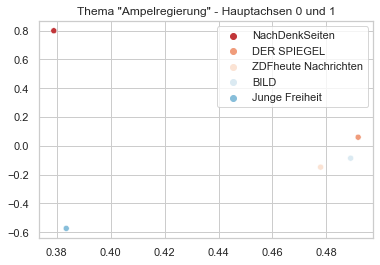

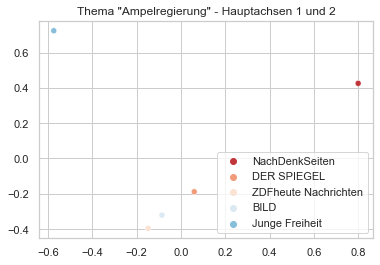

In [8]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

topic = 'Ampelregierung'
N_df = get_N_matrix(topic=topic)
N_df = filter_N_by_information_score(N_df)

r=3

scaler = StandardScaler()
model = TruncatedSVD(n_components=r)

N_scaled = scaler.fit_transform(N_df.values)
N_df_trunc = model.fit_transform(N_scaled)

sns.set(palette='RdBu', style='whitegrid')
sns.scatterplot(model.components_[0], model.components_[1], hue=N_df.columns).set(title=f'Thema "{topic}" - Hauptachsen 0 und 1')
plt.figure()
sns.scatterplot(model.components_[1], model.components_[2], hue=N_df.columns).set(title=f'Thema "{topic}" - Hauptachsen 1 und 2')
plt.show()